# Testing SuperResolution of 1 Image Using DBPN
DBPN - Deep Back-Projection Network

In [1]:
# Imports
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from dbpn import Net as DBPN
import numpy as np
import matplotlib.pyplot as plt

## Setting Parameters

In [2]:
model_path = os.path.join(os.path.expanduser('~'), 'project', 'models', 'DBPN_x8.pth')
print(model_path)
upscale_factor = 8 # Can be 2, 4 or 8
cuda = True # Set True if you're using GPU
gpus=2

seed = 123

/datasets/home/46/646/bkambalu/project/models/DBPN_x8.pth


### Check if Graphic Cards are detected

In [3]:
if cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")
gpus_list=range(gpus)

In [4]:
if cuda:
    torch.cuda.manual_seed(seed)

## Build the DBPN Model
Note: The comments in the original code suggests that this model is actually D-DBPN (Dense-DBPN)

In [5]:
print('===> Building model')
model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=upscale_factor) ###D-DBPN

===> Building model


In [6]:
if cuda:
    model = torch.nn.DataParallel(model, device_ids=gpus_list)

## Load the Model Parameters from Pretrained Model

In [7]:
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage))
    print('Pre-trained SR model is loaded.')

Pre-trained SR model is loaded.


In [8]:
if cuda:
    model = model.cuda(gpus_list[0])
model.eval()

DataParallel(
  (module): Net(
    (feat0): ConvBlock(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): PReLU(num_parameters=1)
    )
    (feat1): ConvBlock(
      (conv): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
      (act): PReLU(num_parameters=1)
    )
    (up1): UpBlock(
      (up_conv1): DeconvBlock(
        (deconv): ConvTranspose2d(64, 64, kernel_size=(12, 12), stride=(8, 8), padding=(2, 2))
        (act): PReLU(num_parameters=1)
      )
      (up_conv2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(12, 12), stride=(8, 8), padding=(2, 2))
        (act): PReLU(num_parameters=1)
      )
      (up_conv3): DeconvBlock(
        (deconv): ConvTranspose2d(64, 64, kernel_size=(12, 12), stride=(8, 8), padding=(2, 2))
        (act): PReLU(num_parameters=1)
      )
    )
    (down1): DownBlock(
      (down_conv1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(12, 12), stride=(8, 8), padding=(2, 2))
        (act): PReL

## Load the Image

In [9]:
transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='/datasets/ee285s-public/', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=1)
#print(len(trainloader[0]))
#for batch in trainloader:
dataiter = iter(trainloader)
 #   inp, name = Variable(batch[0],volatile=True), batch[1]
  #  print(type(inp),len(name))
image_t, label = dataiter.next()

### Define a Function to View any Image (in the form of a `Tensor`)

In [10]:
def imshow(img): # img is a PyTorch Tensor
    #img = img / 2 + 0.5     # unnormalize
    
    # Convert from Torch Tensor to numpy array
    # Squeeze removes the first dimension, which is batch size. Here, it is always 1
    npimg = img.numpy().squeeze()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose is to convert from BGR to RGB

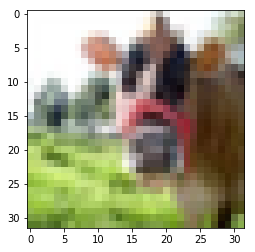

In [11]:
imshow(image_t)

In [12]:
inp = Variable(image_t, volatile=True)
if cuda:
    inp = inp.cuda(gpus_list[0])
prediction = model(inp)

In [13]:
out = prediction.cpu().data

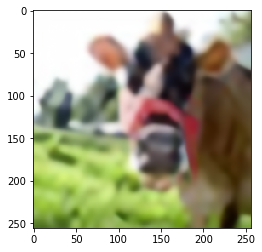

In [14]:
imshow(out)

In [15]:
def x8_forward(img, model, precision='single'):
    def _transform(v, op):
        if precision != 'single': v = v.float()

        v2np = v.data.cpu().numpy()
        if op == 'vflip':
            tfnp = v2np[:, :, :, ::-1].copy()
        elif op == 'hflip':
            tfnp = v2np[:, :, ::-1, :].copy()
        elif op == 'transpose':
            tfnp = v2np.transpose((0, 1, 3, 2)).copy()
        
        ret = torch.Tensor(tfnp).cuda()

        if precision == 'half':
            ret = ret.half()
        elif precision == 'double':
            ret = ret.double()

        return Variable(ret, volatile=v.volatile)

    inputlist = [img]
    for tf in 'vflip', 'hflip', 'transpose':
        inputlist.extend([_transform(t, tf) for t in inputlist])

    outputlist = [model(aug) for aug in inputlist]
    for i in range(len(outputlist)):
        if i > 3:
            outputlist[i] = _transform(outputlist[i], 'transpose')
        if i % 4 > 1:
            outputlist[i] = _transform(outputlist[i], 'hflip')
        if (i % 4) % 2 == 1:
            outputlist[i] = _transform(outputlist[i], 'vflip')
    
    output = reduce((lambda x, y: x + y), outputlist) / len(outputlist)

    return output

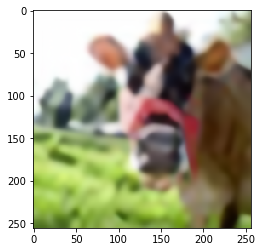

In [23]:
prediction_x8 = x8_forward(inp, model)
out_x8 = prediction_x8.cpu().data
imshow(out_x8)

In [26]:
out== out_x8


( 0 , 0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 0 , 1 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0

( 0 , 2 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.ByteTensor of size 1x3x256x256]

In [27]:
out[0][0][0][0]

0.9998153448104858

In [28]:
out_x8[0][0][0][0]

0.9989520311355591